# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import os

from keras.layers.core import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

Testing if cuda is on GPU

In [2]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


# Spatial Data Generation


In [3]:
path = './data/hmdb51'
path_rowframes = './data/hmdb51/rawframes/'
path_annotations = './data/hmdb51/annotations/'

img_height = 224
img_width = 224
batch_size = 64
num_classes = 51

num_frames_desired = 17     #number of frames per clip
type_frame = 'img'          #img / flow_x / flow_y

In [4]:
def sampling(list, num_frames_desired):
    step = len(list) // (num_frames_desired)
    #selected_frames = list(range(0, len(list), step))[:num_frames_desired]
    sampled_list = list[0:len(list):step][:num_frames_desired]
    return(sampled_list)

def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_height, img_width])
    return image

def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

def find_paths(partition, type_frame, num_frames_desired):
    if partition == 'train':
        video_list = pd.read_csv(f'{path_annotations}/hmdb51_train_split_1_rawframes.txt', sep=" ", header=None) #train
        video_list.columns = ["path", "num_frames_tot", "class"]
    elif partition == 'val':
        video_list = pd.read_csv(f'{path_annotations}/hmdb51_val_split_1_rawframes.txt', sep=" ", header=None) #test
        video_list.columns = ["path", "num_frames_tot", "class"]
    else:
        raise Exception("invalid partition")

    #temp_path = video_list.loc[0]['path'] #da togliere!!!

    paths = []
    classes = []
    for index, row in video_list.iterrows(): #da togliere [:1]
        temp_path = row['path']                    #da rimuovere il commentato
        frame_list = os.listdir(os.path.join(f'./{temp_path}'))

        frame_list_type = [i for i in frame_list if i.startswith(f'{type_frame}')]

        filename = sampling(frame_list_type, num_frames_desired)

        paths.extend([os.path.join('.\\', temp_path, file) for file in filename])
        temp = [row['class']] * num_frames_desired
        classes.extend(temp)

    return(list(zip(paths, classes)))

In [5]:
# ------- create train set
filenames = find_paths(partition='train', type_frame=type_frame, num_frames_desired=num_frames_desired)

random.shuffle(filenames)

zipped = [list(t) for t in zip(*filenames)]

filenames = zipped[0]
labels = zipped[1]

filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
labels_ds = tf.data.Dataset.from_tensor_slices(labels)
ds = tf.data.Dataset.zip((images_ds, labels_ds))
train_ds = configure_for_performance(ds)

In [6]:
frame_number_train = len(filenames)
print(frame_number_train)

60690


In [7]:
# ------- create val test
filenames = find_paths(partition='val', type_frame=type_frame, num_frames_desired=num_frames_desired)

random.shuffle(filenames)

zipped = [list(t) for t in zip(*filenames)]

filenames = zipped[0]
labels = zipped[1]

filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
labels_ds = tf.data.Dataset.from_tensor_slices(labels)
ds = tf.data.Dataset.zip((images_ds, labels_ds))
val_ds = configure_for_performance(ds)

In [8]:
frame_number_val = len(filenames)
print(frame_number_val)

26010


In [9]:
step_per_epoch_train = frame_number_train // batch_size
step_per_epoch_val = frame_number_val // batch_size
print(step_per_epoch_train)
print(step_per_epoch_val)

948
406


# Spatial Stream Finetuned

In [16]:
checkpoint_filepath = './Models/spatial_model{epoch:02d}-{val_loss:.2f}.hdf5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

## ResNet 1

In [17]:
input = tf.keras.layers.Input(shape=(img_height, img_width, 3))

pretrained_model = tf.keras.applications.ResNet50(include_top=False,
                                                  input_tensor=input,
                                                  pooling='avg',
                                                  weights='imagenet')
pretrained_model.trainable = False

resnet_model = Sequential()
resnet_model.add(pretrained_model)

resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(num_classes, activation='softmax'))

print(resnet_model.summary())

resnet_model.compile(optimizer = Adam(learning_rate=0.001), loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 51)                26163     
                                                                 
Total params: 24,662,963
Trainable params: 1,075,251
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [18]:
history_ResNet1_spatial_stream = resnet_model.fit(train_ds, 
                                        validation_data = val_ds, 
                                        epochs=20, 
                                        steps_per_epoch=step_per_epoch_train,
                                        validation_steps=step_per_epoch_val,
                                        callbacks=[model_checkpoint_callback])

948/948 [==============================] - 441s 461ms/step - loss: 0.8278 - sparse_categorical_accuracy: 0.7802 - val_loss: 3.3119 - val_sparse_categorical_accuracy: 0.3336


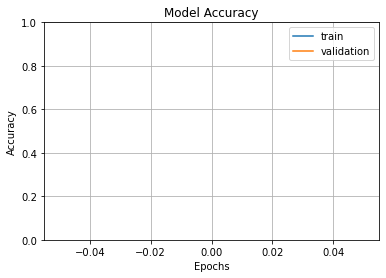

In [20]:
fig1 = plt.gcf()
plt.plot(history_ResNet1_spatial_stream.history['sparse_categorical_accuracy'])
plt.plot(history_ResNet1_spatial_stream.history['val_sparse_categorical_accuracy'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.savefig('resnet_1.png')
plt.show()

## ResNet 2

In [14]:
def build_model(num_classes, img_size=224):
    input = tf.keras.layers.Input(shape=(img_size, img_size, 3))
    model = tf.keras.applications.ResNet50(include_top=False, input_tensor=input, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    output = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(input, output, name="ResNet")
    model.compile(optimizer='adam', loss = "sparse_categorical_crossentropy", metrics = ['sparse_categorical_accuracy'])
    return model 

model = build_model(num_classes)
print(model.summary())

Model: "ResNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                             

In [ ]:
history_ResNet2_spatial_stream = model.fit(train_ds, 
                                        validation_data = val_ds, 
                                        batch_size=batch_size, 
                                        epochs=20, 
                                        steps_per_epoch=step_per_epoch_train, 
                                        validation_steps=step_per_epoch_val,
                                        callbacks=[model_checkpoint_callback])

In [ ]:
fig2 = plt.gcf()
plt.plot(history_ResNet2_spatial_stream.history['sparse_categorical_accuracy'])
plt.plot(history_ResNet2_spatial_stream.history['val_sparse_categorical_accuracy'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.savefig('resnet_2.png')
plt.show()